In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob1
import os
import pandas as pd
from datetime import datetime
import time

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 5,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': 32.0,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': 30,
         'axes.titlesize': 30,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': 30,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': 30,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)

In [3]:
def Gaussian_fit(x,y,isplot=False):
    from lmfit.models import GaussianModel
    mod = GaussianModel()
    params = mod.guess(y,x=x)
    res = mod.fit(y,params,x=x)
    if isplot:
        dummyx = np.linspace(min(x),max(x),1000)
        plt.plot(x,y)
        plt.plot(dummyx,mod.eval(res.params,x=dummyx))
        print (res.fit_report())
    return res, mod

In [4]:
def read_spectrum_analyzer_csv(filename,spectrograph=False,linear=False,isplot=False,issaved=False):
    dbm_linear = lambda y: 50*0.001*(10**(y/10))
    def convert_dates_to_utc_seconds(timestamp_str):
        t0 = datetime.strptime(timestamp_str, '%d.%b %y%H:%M:%S.%f')
        timeref = datetime(1970,1,1)
        return (t0 - datetime(1970,1,1)).total_seconds()
    
    if not spectrograph:
        df = pd.read_csv(filename,sep=';',skiprows=6)
        list_of_column_names = df.keys()

        freq = df[list_of_column_names[0]].str.replace(',', '.')
        amplitude = df[list_of_column_names[1]].str.replace(',', '.')

        freqoffset = amplitude[np.where(freq == "Freq Offset")[0][0]]
        reflevel_dBm = amplitude[np.where(freq == "Ref Level")[0][0]]
        start = np.where(freq == "Values")[0][0]+1

        stop = np.where(freq == "Trace")[0][1]

        freq = np.array(freq[start:stop],dtype='float')  + float(freqoffset)
        amplitude = np.array(amplitude[start:stop],dtype='float') + float(reflevel_dBm)
        if linear:
            amplitude = dbm_linear(amplitude)
            ylabel = 'Amplitude (linear)'
        else:
            ylabel = 'Amplitude (dBm)'
        if isplot:
            f = plt.figure(figsize=(10,10))
            f.subplots_adjust(hspace=0.4)
            ax1 = f.add_subplot(211)
            ax = f.add_subplot(212)

            ax.semilogx(freq,amplitude,color='navy')
            ax.set_xlabel('Freq. (Hz)')
            ax.set_ylabel('%s'%ylabel)

            ax1.plot(freq,amplitude,color='navy')
            ax1.set_xlabel('Freq. (Hz)')
            ax1.set_ylabel('%s'%ylabel)
            if issaved:
                f.savefig(filename[:-4]+'_data.png',dpi=100,bbox_inches='tight',facecolor='white')
                print ('Figure saved as %s'%(filename[:-4]+'_data.png'))
        return freq, amplitude
    else:
        df = pd.read_csv(filename,sep=';',skiprows=6,decimal=",")
        list_of_column_names = df.keys()

        freq = df[list_of_column_names[0]].str.replace(',', '.')
        amplitude = df[list_of_column_names[1]].str.replace(',', '.')
        timestamps = df[list_of_column_names[2]].str.replace(',', '.')
        try:
            freqoffset = amplitude[np.where(freq == "Freq Offset")[0][0]]
            reflevel_dBm = amplitude[np.where(freq == "Ref Level")[0][0]]
        except:
            freqoffset = 0
            reflevel_dBm = 0
        frame_start_index = np.where(freq == "Timestamp")[0]
        start = np.where(freq == "Values")[0][0]+1
        stop = np.where(freq == "Trace")[0][1]


        ## time stamps

        time_raw =  np.array(amplitude[frame_start_index])+np.array(timestamps[frame_start_index])
        time_s = np.zeros(len(time_raw))
        t0 = convert_dates_to_utc_seconds(timestamp_str=time_raw[0]) 
        for j in range(len(time_raw)):
            time_s[j] = convert_dates_to_utc_seconds(timestamp_str=time_raw[j]) 

        ## histogram traces array
        freq_ary = np.array(freq[start:stop],dtype='float')  + float(freqoffset)
        amplitude_ary = np.zeros((len(time_raw),len(freq_ary)))
        for j in range(len(time_raw)):
            amplitude_ary[j] = np.array(amplitude[frame_start_index[j]+1:frame_start_index[j]+1+len(freq_ary)],dtype='float')  + float(reflevel_dBm)
        
        amplitude1 = np.array(amplitude[start:stop],dtype='float') + float(reflevel_dBm)
        
        if linear:
            amplitude1 = dbm_linear(amplitude1)
            amplitude_ary = dbm_linear(amplitude_ary)
            keyword = 'linear_'
            ylabel = 'Amplitude (linear)'
        else:
            ylabel = 'Amplitude (dBm)'
            keyword = ''
            
        if isplot:
            f = plt.figure(figsize=(10,10))
            f.subplots_adjust(hspace=0.05)
            ax = f.add_subplot(211)
            ax.set_title('Average')
            ax.plot(freq_ary,np.mean(amplitude_ary,axis=0),color='navy')
            ax.set_ylabel('%s'%ylabel)
            ax.set_xticklabels([])

            ax1 = f.add_subplot(212)
            im = ax1.pcolormesh(freq_ary,time_s,amplitude_ary,cmap='inferno_r')
#             cax = f.add_axes([0.57, 0.2, 0.3, 0.05])
#             cbar = f.colorbar(im, cax=cax,orientation='horizontal')
#             cbar.ax.set_title('%s'%ylabel)
            ax1.set_xlabel('Freq. (Hz)')
            ax1.set_ylabel('Time (s)')
            if issaved:
                f.savefig(filename[:-4]+keyword+'_data.png',dpi=100,bbox_inches='tight',facecolor='white')
                print ('Figure saved as %s'%(filename[:-4]+keyword+'_data.png'))
        return freq_ary,time_s,amplitude_ary

In [5]:
directory = r'Z:\qfc\users\Armin\spectrum_analyser_traces'
# directory = r'C:\Users\ZakKoong\Desktop'
flst = glob1(directory,'*07042022**.csv')
flst

['07042022-linear001_001.CSV',
 '07042022-linear002.CSV',
 '07042022-linearqsim.CSV',
 '07042022-linearqsim_001.CSV',
 '07042022-linearqsim_002.CSV',
 '07042022qsimqfcrfonoff_effects.CSV']

# Spectrograph data

Figure saved as Z:\qfc\users\Armin\spectrum_analyser_traces\07042022-linear002linear__data.png


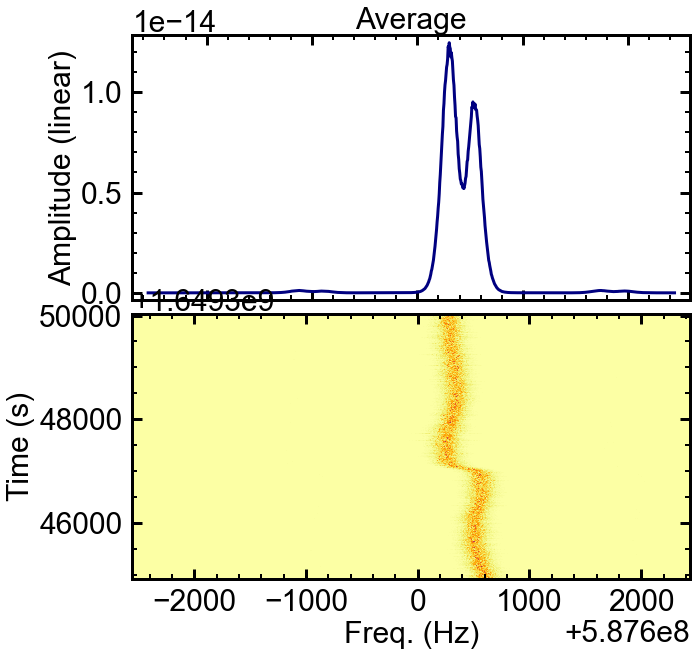

In [6]:
filename_spectrograph = os.path.join(directory,flst[1])

freq,time_ary,amplitude = read_spectrum_analyzer_csv(filename_spectrograph,spectrograph= True,
                                                      linear=True,isplot=True,issaved= True)

In [ ]:
aa